

```
# This is formatted as code
```

NAME : ALBERT GANDHI A

ROLL NO : CB.SC.I5DAS20003

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'age-detection-human-faces-18-60-years:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3933739%2F6842818%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240624%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240624T170832Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6d98007344772e809c67a73231e281514099c06d685bd55d3489a95e0f15f27fdb0bd15d923ebcd820fc50a81c7f85396d48d7d728539dc7ba87e0aad882c1a6eff614904ee354a58ecee0bb6b1464d8ca70f35d399d011f4de849c78f69dc2653dc508657c1a59a90335dd2385afa947e087a3a4490acb038c0cf37c6928a0a9bc75e04b2feb3242c1c4753b3c93621406b5a60a666785784ebd3e6fcebe4e5d66922e3ff212d41cb16d96ce268af047bbb537947f9dc8c21e51a952357e8e9472593159c7eaf0ae74eed4151c165cc43c3c84290bcb1f69112fd85e028329030082612a8e4d7a4ec64e21df26e864cc3bb01794fc236176d52ae179af9bec9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 353068636 bytes downloaded
Downloaded and uncompressed: age-detection-human-faces-18-60-years
Data source import complete.


In [ ]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_data_path = '/kaggle/input/age-detection-human-faces-18-60-years/train'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
train_df

filepaths  label
0    /kaggle/input/age-detection-human-faces-18-60-...  51-60
1    /kaggle/input/age-detection-human-faces-18-60-...  51-60
2    /kaggle/input/age-detection-human-faces-18-60-...  51-60
3    /kaggle/input/age-detection-human-faces-18-60-...  51-60
4    /kaggle/input/age-detection-human-faces-18-60-...  51-60
..                                                 ...    ...
120  /kaggle/input/age-detection-human-faces-18-60-...  21-30
121  /kaggle/input/age-detection-human-faces-18-60-...  21-30
122  /kaggle/input/age-detection-human-faces-18-60-...  21-30
123  /kaggle/input/age-detection-human-faces-18-60-...  21-30
124  /kaggle/input/age-detection-human-faces-18-60-...  21-30

[125 rows x 2 columns]

In [ ]:
test_data_path = '/kaggle/input/age-detection-human-faces-18-60-years/test'
filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
test_df

filepaths  label
0   /kaggle/input/age-detection-human-faces-18-60-...  51-60
1   /kaggle/input/age-detection-human-faces-18-60-...  51-60
2   /kaggle/input/age-detection-human-faces-18-60-...  51-60
3   /kaggle/input/age-detection-human-faces-18-60-...  51-60
4   /kaggle/input/age-detection-human-faces-18-60-...  51-60
5   /kaggle/input/age-detection-human-faces-18-60-...  18-20
6   /kaggle/input/age-detection-human-faces-18-60-...  18-20
7   /kaggle/input/age-detection-human-faces-18-60-...  18-20
8   /kaggle/input/age-detection-human-faces-18-60-...  18-20
9   /kaggle/input/age-detection-human-faces-18-60-...  18-20
10  /kaggle/input/age-detection-human-faces-18-60-...  41-50
11  /kaggle/input/age-detection-human-faces-18-60-...  41-50
12  /kaggle/input/age-detection-human-faces-18-60-...  41-50
13  /kaggle/input/age-detection-human-faces-18-60-...  41-50
14  /kaggle/input/age-detection-human-faces-18-60-...  41-50
15  /kaggle/input/age-detection-human-faces-18-60-...  31-40
16  /kaggle/input/age-detection-human-faces-18-60-...  31-40
17  /kaggle/input/age-detection-human-faces-18-60-...  31-40
18  /kaggle/input/age-detection-human-faces-18-60-...  31-40
19  /kaggle/input/age-detection-human-faces-18-60-...  31-40
20  /kaggle/input/age-detection-human-faces-18-60-...  21-30
21  /kaggle/input/age-detection-human-faces-18-60-...  21-30
22  /kaggle/input/age-detection-human-faces-18-60-...  21-30
23  /kaggle/input/age-detection-human-faces-18-60-...  21-30
24  /kaggle/input/age-detection-human-faces-18-60-...  21-30

## Spliting data into valid and test

In [ ]:
valid,test = train_test_split(test_df,train_size=0.5,shuffle=True,random_state=42)

## Image Data Generator ##

In [ ]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 125 validated image filenames belonging to 5 classes.
Found 12 validated image filenames belonging to 5 classes.
Found 13 validated image filenames belonging to 5 classes.


## Show sample from train data

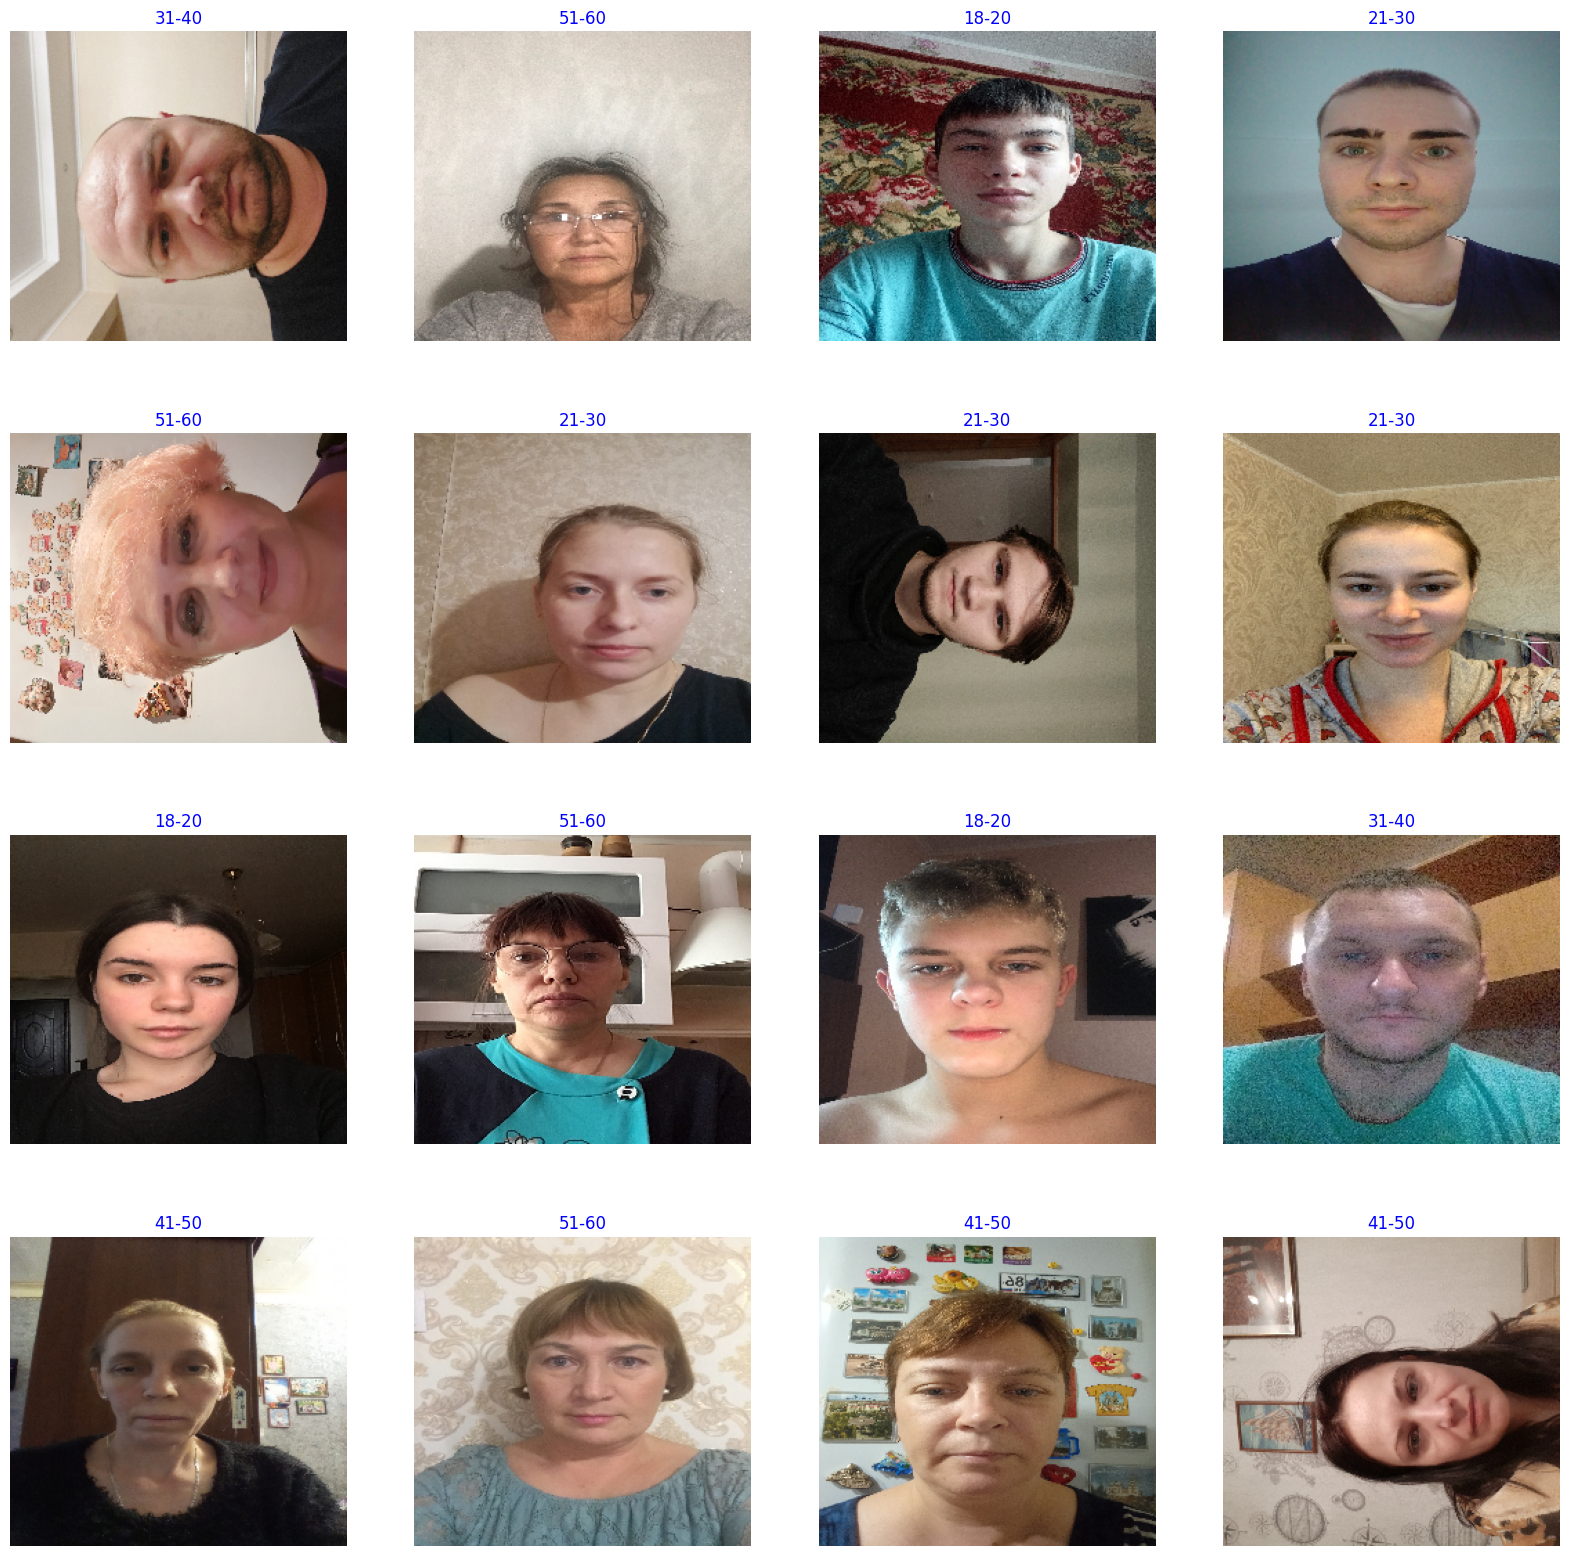

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

## Model

In [ ]:
img_shape = (img_size[0],img_size[1],3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

43941136/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                         

## Iteration

In [ ]:
epochs = 10
history = model.fit(x= train_gen , epochs = epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/10
8/8 [==============================] - 141s 12s/step - loss: 10.7403 - accuracy: 0.2240 - val_loss: 12.2888 - val_accuracy: 0.1667
Epoch 2/10
8/8 [==============================] - 89s 11s/step - loss: 8.7301 - accuracy: 0.6400 - val_loss: 10.9624 - val_accuracy: 0.2500
Epoch 3/10
8/8 [==============================] - 89s 11s/step - loss: 8.0753 - accuracy: 0.8480 - val_loss: 11.0732 - val_accuracy: 0.1667
Epoch 4/10
8/8 [==============================] - 100s 12s/step - loss: 7.7297 - accuracy: 0.9280 - val_loss: 10.9766 - val_accuracy: 0.1667
Epoch 5/10
8/8 [==============================] - 91s 11s/step - loss: 7.5757 - accuracy: 0.9520 - val_loss: 10.3971 - val_accuracy: 0.1667
Epoch 6/10
8/8 [==============================] - 91s 11s/step - loss: 7.4332 - accuracy: 0.9840 - val_loss: 9.9978 - val_accuracy: 0.0000e+00
Epoch 7/10
8/8 [==============================] - 94s 12s/step - loss: 7.3248 - accuracy: 0.9600 - val_loss: 9.6121 - val_accuracy: 0.0833
Epoch 8/10
8/8 

## Model Performance

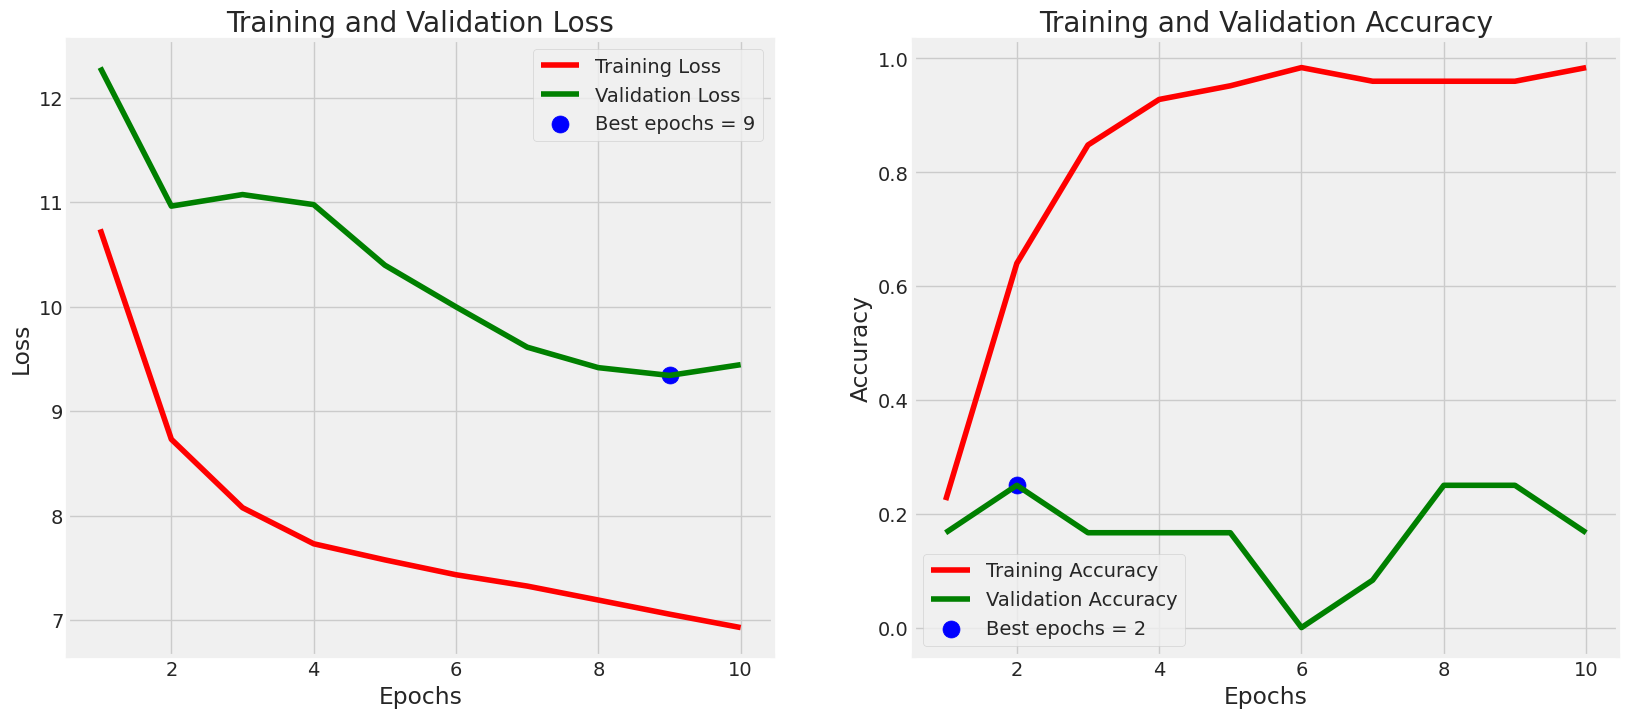

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

## Model Evaluation

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

 8/16 [==============>...............] - ETA: 24s - loss: 6.9932 - accuracy: 1.0000

 1/16 [>.............................] - ETA: 48s - loss: 9.4445 - accuracy: 0.1667

 1/16 [>.............................] - ETA: 37s - loss: 9.5142 - accuracy: 0.3077

16/16 [==============================] - 3s 4ms/step - loss: 9.5142 - accuracy: 0.3077
Train Loss:  6.993156433105469
Train Accuracy:  1.0
--------------------
Validation Loss:  9.444518089294434
Validation Accuracy:  0.1666666716337204
--------------------
Test Loss:  9.514249801635742
Test Accuracy:  0.3076923191547394


## Model prediction
## Confusion Matrix and Classification report

In [ ]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds,axis=1)

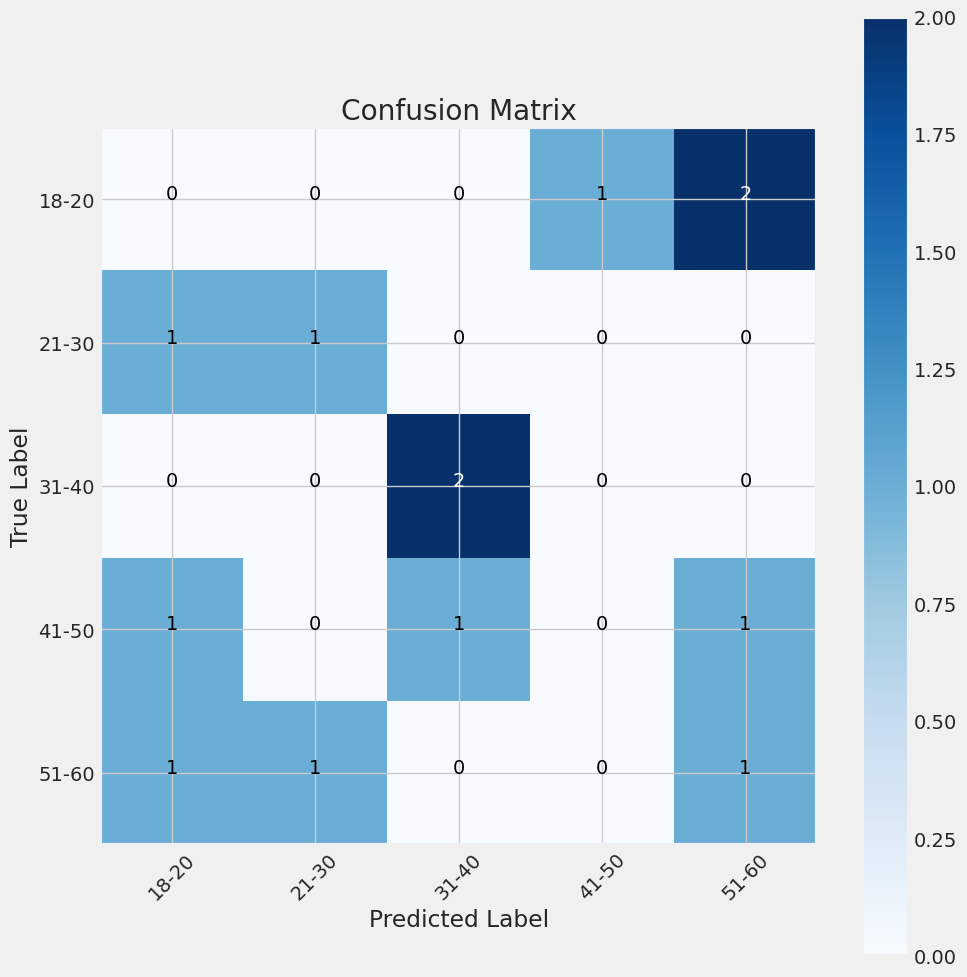

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

       18-20       0.00      0.00      0.00         3
       21-30       0.50      0.50      0.50         2
       31-40       0.67      1.00      0.80         2
       41-50       0.00      0.00      0.00         3
       51-60       0.25      0.33      0.29         3

    accuracy                           0.31        13
   macro avg       0.28      0.37      0.32        13
weighted avg       0.24      0.31      0.27        13



In [ ]:
resize = 224
label = ("18-20","21-30","31-40","41-50","51-60")

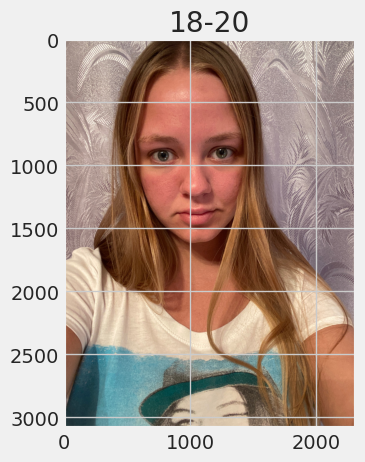

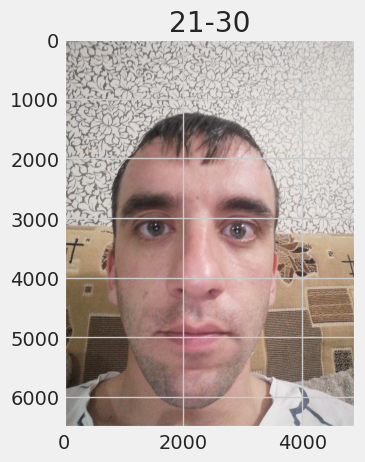

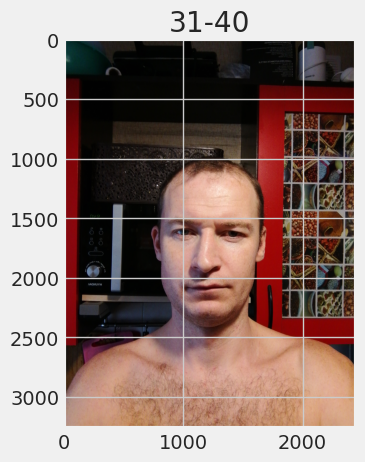

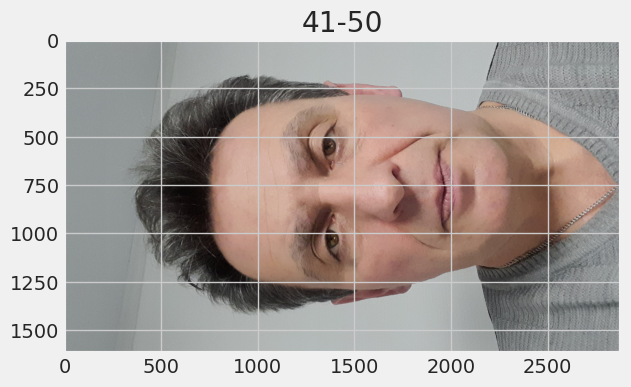

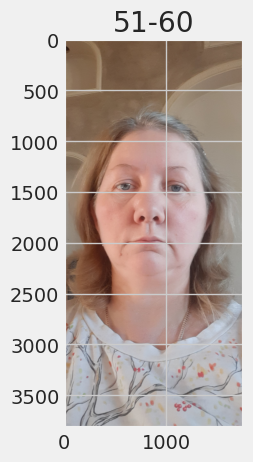

In [ ]:
image1 = Image.open("/kaggle/input/age-detection-human-faces-18-60-years/test/18-20/25.jpg")
image2 = Image.open("/kaggle/input/age-detection-human-faces-18-60-years/test/21-30/27.jpg")
image3 = Image.open("/kaggle/input/age-detection-human-faces-18-60-years/test/31-40/29.jpg")
image4 = Image.open("/kaggle/input/age-detection-human-faces-18-60-years/test/41-50/26.jpg")
image5 = Image.open("/kaggle/input/age-detection-human-faces-18-60-years/test/51-60/26.jpg")


plt.figure('image1')
plt.title("18-20")
plt.imshow(image1)

plt.figure('image2')
plt.title("21-30")
plt.imshow(image2)


plt.figure("image3")
plt.title("31-40")
plt.imshow(image3)

plt.figure("image4")
plt.title("41-50")
plt.imshow(image4)

plt.figure("image5")
plt.title("51-60")
plt.imshow(image5)